In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.filevideostream import FileVideoStream
from utils.functions import *

#### 1. Prueba con imagen

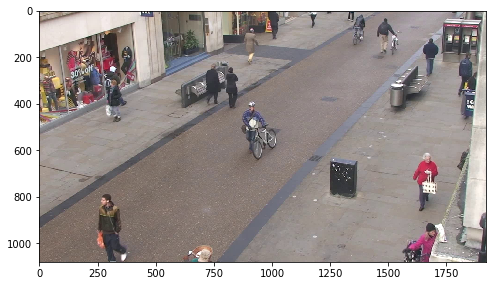

In [2]:
original = cv2.cvtColor(cv2.imread('multimedia/calibration_frame.jpg'), cv2.COLOR_BGR2RGB)
image_copy = original.copy()

plt.figure(figsize=(8,8))
plt.imshow(image_copy)
plt.show()

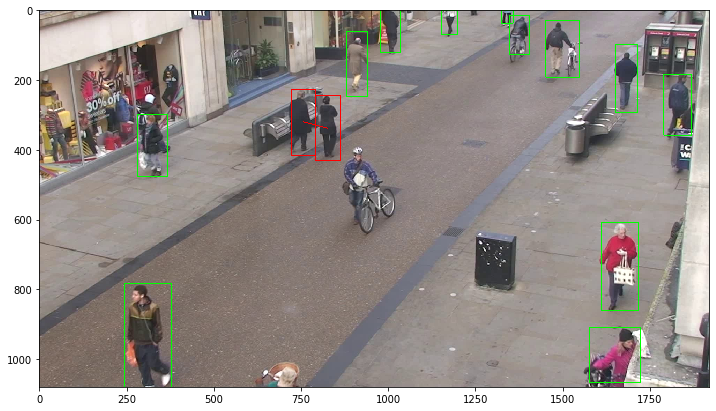

CPU times: user 4.67 s, sys: 171 ms, total: 4.84 s
Wall time: 1.46 s


In [3]:
%%time
confidence_threshold = 0.5
nms_threshold = 0.4
min_distance = 100
width = 416
height = 416

config = 'models/yolov3-608/yolov3.cfg'
weights = 'models/yolov3-608/yolov3.weights'
classes = 'models/yolov3-608/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

model = create_model(config, weights, use_gpu=False)
output_layers = get_output_layers(model)
blob = blob_from_image(image_copy, (width, height))
outputs = predict(blob, model, output_layers)
boxes, nms_boxes, class_ids = non_maximum_suppression(image_copy, outputs, confidence_threshold, nms_threshold)
person_boxes = get_domain_boxes(coco_classes, class_ids, nms_boxes, boxes, domain_class='person')

good, bad = people_distances_bird_eye_view(person_boxes, min_distance)
new_image  = draw_new_image_with_boxes(image_copy, good, bad, min_distance, draw_lines=True)

plt.figure(figsize=(12,12))
plt.imshow(new_image)
plt.show()
#image = cv2.resize(new_image, (600, 400))    
#cv2.imshow('Frame', image[:,:,::-1])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#### 2. Prueba con video

In [4]:
confidence_threshold = 0.5
nms_threshold = 0.4
min_distance = 100
width = 416
height = 416

config = 'models/yolov3-608/yolov3.cfg'
weights = 'models/yolov3-608/yolov3.weights'
classes = 'models/yolov3-608/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')
    
video = cv2.VideoCapture('multimedia/TownCentre-test.mp4')
#fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#writer = cv2.VideoWriter('te')
    
model = create_model(config, weights, use_gpu=True)
output_layers = get_output_layers(model)


while True:
    _,frame = video.read()
    
    if frame is None:
        break
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    blob = blob_from_image(image, (width, height))
    outputs = predict(blob, model, output_layers)
    boxes, nms_boxes, class_ids = non_maximum_suppression(image, outputs, confidence_threshold, nms_threshold)
    person_boxes = get_domain_boxes(coco_classes, class_ids, nms_boxes, boxes, domain_class='person')

    good, bad = people_distances_bird_eye_view(person_boxes, min_distance)
    new_image  = draw_new_image_with_boxes(image, good, bad, min_distance, draw_lines=True)
    
    cv2.imshow('Frame', image[:,:,::-1])
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

#### 3. Prueba con video rápido

In [3]:
confidence_threshold = 0.5
nms_threshold = 0.4
min_distance = 100
width = 416
height = 416

config = 'models/yolov3-608/yolov3.cfg'
weights = 'models/yolov3-608/yolov3.weights'
classes = 'models/yolov3-608/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

fast_video = FileVideoStream('multimedia/TownCentre-test.mp4').start()

model = create_model(config, weights, use_gpu=True)
output_layers = get_output_layers(model)


while fast_video.more():
    
    frame = fast_video.read()
    
    if frame is None:
        break
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    blob = blob_from_image(image, (width, height))
    outputs = predict(blob, model, output_layers)
    boxes, nms_boxes, class_ids = non_maximum_suppression(image, outputs, confidence_threshold, nms_threshold)
    person_boxes = get_domain_boxes(coco_classes, class_ids, nms_boxes, boxes, domain_class='person')

    good, bad = people_distances_bird_eye_view(person_boxes, min_distance)
    new_image  = draw_new_image_with_boxes(image, good, bad, min_distance, draw_lines=True)
    
    image = cv2.resize(image, (400, 200))    
    cv2.imshow('Frame', image[:,:,::-1])
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
video.release()
cv2.destroyAllWindows()

NameError: name 'video' is not defined